## 0. Import Libraries  

**Loading essential Python libraries**  

We begin by importing all the standard libraries required for this project.  
These include tools for **data processing**, **visualization**, and **machine learning**.  

- `pandas` and `numpy` for data handling,  
- `matplotlib` and `seaborn` for visualization,  
- `scikit-learn` for preprocessing and modeling,  
- and other utilities as needed throughout the workflow.  

This ensures all dependencies are available before executing later steps.


In [1]:
# ==== INSTALL ALL REQUIRED PACKAGES ====
# Run this cell once to ensure your environment has all dependencies.
# If already installed, pip will just confirm the version.

!pip install pandas numpy matplotlib seaborn scikit-learn pyyaml


In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt


## 1. Configure Paths and Constants  

**Set up dataset paths and preprocessing rules**  

We configure the working environment by pointing `UKDALE_ROOT` to the dataset folder,  
which contains **house_1** and its metadata (`labels.dat`).  

Next, we define key constants used throughout preprocessing:  
- **Cadence:** 6-second sampling interval,  
- **Gap filling:** 2-minute forward-fill limit,  
- **On-threshold:** 5 W to detect appliance activity.  

Finally, we perform a two-step check to confirm appliance labels are available:  
1. **Preferred:** load directly from `labels.dat`,  
2. **Fallback:** use a hardcoded mapping from the official UK-DALE README for House 1.  

This ensures the pipeline can always construct `df_labels` with valid channel-to-appliance mappings,  
including the `aggregate` mains channel required for analysis.  



In [3]:
# ==== Configure Paths and Constants ====
from pathlib import Path
import pandas as pd

# Paths
UKDALE_ROOT = Path("Unsupervised_Dataset/UK-DALE-disaggregated").resolve()
house1 = UKDALE_ROOT / "house_1"
labels_path = house1 / "labels.dat"

# Preprocessing constants
TARGET_RESAMPLE_SEC  = 6     # align to 6 s cadence
SHORT_GAP_LIMIT_SEC  = 120   # ffill gaps < 2 min; >= 2 min -> 0
ON_POWER_THRESHOLD_W = 5     # on/off threshold for appliances

# Appliance labels: prefer labels.dat, fallback to hardcoded House 1 mapping
def load_labels_df():
    # Preferred: load labels.dat if available
    if labels_path.exists():
        df = pd.read_csv(labels_path, sep=r"\s+", header=None, names=["channel","appliance"], engine="python")
        df["channel"] = df["channel"].astype(int)
        df["appliance"] = df["appliance"].astype(str).str.strip().str.lower()
        # Ensure aggregate is included
        if not (df["appliance"] == "aggregate").any():
            df = pd.concat([df, pd.DataFrame([{"channel":1,"appliance":"aggregate"}])], ignore_index=True)
        return df.sort_values("channel").drop_duplicates().reset_index(drop=True)

    # Fallback: hardcoded House 1 mapping from UK-DALE README
    house1_labels = {
        1:"aggregate", 2:"boiler", 3:"solar_thermal_pump", 4:"laptop", 5:"washing_machine",
        6:"dishwasher", 7:"tv", 8:"kitchen_lights", 9:"htpc", 10:"kettle", 11:"toaster",
        12:"fridge", 13:"microwave", 14:"lcd_office", 15:"hifi_office", 16:"breadmaker",
        17:"amp_livingroom", 18:"adsl_router", 19:"livingroom_s_lamp", 20:"soldering_iron",
        21:"gigE_&_USBhub", 22:"hoover", 23:"kitchen_dt_lamp", 24:"bedroom_ds_lamp",
        25:"lighting_circuit", 26:"livingroom_s_lamp2", 27:"iPad_charger",
        28:"subwoofer_livingroom", 29:"livingroom_lamp_tv", 30:"DAB_radio_livingroom",
        31:"kitchen_lamp2", 32:"kitchen_phone&stereo", 33:"utilityrm_lamp",
        34:"samsung_charger", 35:"bedroom_d_lamp", 36:"coffee_machine",
        37:"kitchen_radio", 38:"bedroom_chargers", 39:"hair_dryer", 40:"straighteners",
        41:"iron", 42:"gas_oven", 43:"data_logger_pc", 44:"childs_table_lamp",
        45:"childs_ds_lamp", 46:"baby_monitor_tx", 47:"battery_charger",
        48:"office_lamp1", 49:"office_lamp2", 50:"office_lamp3", 51:"office_pc",
        52:"office_fan", 53:"LED_printer"
    }
    df = pd.DataFrame(
        [{"channel": ch, "appliance": name.lower()} for ch, name in house1_labels.items()]
    )
    return df.sort_values("channel").reset_index(drop=True)

# Load labels
df_labels = load_labels_df()
print(f"Dataset root : {UKDALE_ROOT}")
print(f"House 1      : {house1}")
print("Labels df    :", df_labels.shape, "rows")


Dataset root : C:\Users\magnu\OneDrive - Kristiania\Autum 2025\Introduction AI\IAI4100_Exam_2025_Spring\02_Unsupervised\Unsupervised_Dataset\UK-DALE-disaggregated
House 1      : C:\Users\magnu\OneDrive - Kristiania\Autum 2025\Introduction AI\IAI4100_Exam_2025_Spring\02_Unsupervised\Unsupervised_Dataset\UK-DALE-disaggregated\house_1
Labels df    : (53, 2) rows


In [4]:
# Global constants used throughout the pipeline
TARGET_RESAMPLE_SEC  = 6     # align to 6 s cadence
SHORT_GAP_LIMIT_SEC  = 120   # ffill gaps < 2 min; >= 2 min -> 0
ON_POWER_THRESHOLD_W = 5     # on/off threshold for appliances


### 1.1 Read Labels and Verify Mains Channel  

**Identify and validate the aggregate mains channel**  

We load `labels.dat` and normalize the appliance text for consistency.  
From this file, we locate the row where the appliance is labeled as **'aggregate'**,  
which provides the channel ID for the whole-house mains.  

Steps performed:  
- Load `labels.dat` into memory,  
- Normalize label text,  
- Locate the entry for **aggregate**,  
- Assert that the corresponding `channel_<id>.dat` file exists.  

This ensures the aggregate mains channel is correctly identified before continuing.


In [5]:
# Load labels and normalize
df_labels = pd.read_csv(
    labels_path,
    sep=r"\s+",
    header=None,
    names=["channel", "appliance"],
    engine="python"
)
df_labels["appliance"] = df_labels["appliance"].astype(str).str.strip().str.lower()
df_labels["channel"]   = pd.to_numeric(df_labels["channel"], errors="raise").astype(int)

# Find mains ("aggregate")
hits = df_labels.loc[df_labels["appliance"] == "aggregate", "channel"]
assert not hits.empty, "No label named 'aggregate' found in labels.dat"
if len(hits) > 1:
    print("Multiple 'aggregate' entries in labels.dat; using the first.")
MAINS_CHANNEL = int(hits.iloc[0])

# Verify the mains file exists
mains_path = house1 / f"channel_{MAINS_CHANNEL}.dat"
assert mains_path.exists(), f"Expected mains file not found: {mains_path.name}"

print(f"Aggregate label -> channel_{MAINS_CHANNEL}.dat")

Aggregate label -> channel_1.dat


## 2. Load Mains Data and Align to 6-Second Grid  

**Prepare the aggregate mains signal for analysis**  

We load the aggregate channel (`channel_<aggregate_id>.dat`) for **House 1**  
and convert the UNIX timestamps into **UTC datetimes**.  
The signal is then reindexed onto a strict **6-second grid** for consistency.  

Missing data is handled as follows:  
- **Short gaps (< 2 minutes):** filled using forward-fill,  
- **Longer gaps (≥ 2 minutes):** replaced with `0`.  

The result is a clean and tidy DataFrame, `df_mains`,  
containing a single column: **`mains_W`**, representing the whole-house power usage.  


In [6]:
def load_mains_6s(house_dir: Path, channel_id: int, value_col: str = "mains_W") -> pd.DataFrame:
    
    p = house_dir / f"channel_{channel_id}.dat"
    df = pd.read_csv(p, sep=r"\s+", header=None, names=["ts", value_col], engine="python")
    df["ts"] = pd.to_datetime(df["ts"], unit="s", utc=True)
    df = df.set_index("ts").sort_index()

    # Build full 6 s index over the span and reindex
    full_idx = pd.date_range(df.index.min(), df.index.max(),
                             freq=f"{TARGET_RESAMPLE_SEC}s", tz="UTC")
    df = df.reindex(full_idx)

    # Forward-fill short gaps (< 2 min), then fill the rest with 0
    limit_steps = int(SHORT_GAP_LIMIT_SEC / TARGET_RESAMPLE_SEC)
    df[value_col] = df[value_col].astype(float).ffill(limit=limit_steps).fillna(0.0)

    return df

# Reload mains
df_mains = load_mains_6s(house1, MAINS_CHANNEL)

print("Reloaded mains (aggregate)")
print(df_mains.head(10))
print(df_mains.tail(10))

Reloaded mains (aggregate)
                           mains_W
2012-11-09 22:28:15+00:00    599.0
2012-11-09 22:28:21+00:00    582.0
2012-11-09 22:28:27+00:00    600.0
2012-11-09 22:28:33+00:00    586.0
2012-11-09 22:28:39+00:00    586.0
2012-11-09 22:28:45+00:00    586.0
2012-11-09 22:28:51+00:00    586.0
2012-11-09 22:28:57+00:00    586.0
2012-11-09 22:29:03+00:00    586.0
2012-11-09 22:29:09+00:00    586.0
                           mains_W
2015-01-05 06:14:51+00:00    207.0
2015-01-05 06:14:57+00:00    202.0
2015-01-05 06:15:03+00:00    203.0
2015-01-05 06:15:09+00:00    204.0
2015-01-05 06:15:15+00:00    203.0
2015-01-05 06:15:21+00:00    201.0
2015-01-05 06:15:27+00:00    201.0
2015-01-05 06:15:33+00:00    201.0
2015-01-05 06:15:39+00:00    201.0
2015-01-05 06:15:45+00:00    201.0


## 3. Load Appliance Channels and Add On/Off Flags  

**Prepare target appliance signals for evaluation**  

We select a small set of **benchmark appliances** for House 1,  
using `labels.dat` to map appliance names to their corresponding channel IDs.  

For each appliance channel:  
- Load `channel_<id>.dat`,  
- Convert to a strict **6-second grid**,  
- Apply the **2-minute gap rule** (forward-fill if < 2 minutes, otherwise set to 0).  

Additionally, we create simple **on/off indicators** for each appliance  
using a threshold of **≈ 5 W**, enabling event-level evaluation later in the workflow.  


In [7]:
TARGET_APPLIANCES = [
    "fridge",
    "kettle",
    "dishwasher",
    "washing_machine",
    "microwave",
    "kitchen_lights",
]

def find_channel_for_name(df_labels: pd.DataFrame, name: str) -> int | None:
    hit = df_labels.loc[df_labels["appliance"].str.lower() == name.lower(), "channel"]
    return int(hit.iloc[0]) if not hit.empty else None

def load_channel_raw_6s(house_dir: Path, ch: int, col_name: str) -> pd.DataFrame:
    p = house_dir / f"channel_{ch}.dat"
    df = pd.read_csv(p, sep=r"\s+", header=None, names=["ts", col_name], engine="python")
    df["ts"] = pd.to_datetime(df["ts"], unit="s", utc=True)
    df[col_name] = pd.to_numeric(df[col_name], errors="coerce")
    return df.set_index("ts").sort_index()

def align_to_mains_grid(
    df: pd.DataFrame,
    col: str,
    mains_index: pd.DatetimeIndex,
    short_gap_limit_s: int = 120,
    step_s: int = 6,
) -> pd.DataFrame:
    

    """
    Reindex an appliance series to the mains grid:
    - forward-fill gaps shorter than limit
    - fill longer gaps with 0
    """
    out = df.reindex(mains_index)
    limit_steps = int(short_gap_limit_s / step_s)
    out[col] = out[col].astype(float).ffill(limit=limit_steps).fillna(0.0)
    return out[[col]]

def make_on_flag(series_w: pd.Series, thr_w: float = 5.0) -> pd.Series:
    return (series_w >= thr_w).astype("int8")

# Map names -> channels (only those present)
name_to_channel: dict[str, int] = {}
for name in TARGET_APPLIANCES:
    ch = find_channel_for_name(df_labels, name)
    if ch is not None:
        name_to_channel[name] = ch

aligned_frames = []
missing_files = []
for name, ch in name_to_channel.items():
    try:
        df_raw = load_channel_raw_6s(house1, ch, name)
        df_aln = align_to_mains_grid(
            df_raw,
            name,
            df_mains.index,
            short_gap_limit_s=SHORT_GAP_LIMIT_SEC,
            step_s=TARGET_RESAMPLE_SEC,
        )
        aligned_frames.append(df_aln)
    except FileNotFoundError:
        missing_files.append((name, ch))

# Build df_appliances on the mains grid
df_appliances = (
    pd.concat(aligned_frames, axis=1).fillna(0.0)
    if aligned_frames
    else pd.DataFrame(index=df_mains.index)
)

# Add _on flags
for col in [c for c in df_appliances.columns if not c.endswith("_on")]:
    df_appliances[col + "_on"] = make_on_flag(df_appliances[col], ON_POWER_THRESHOLD_W)

print("Loaded appliances (name -> channel):")
for name, ch in name_to_channel.items():
    ok = "OK" if name in df_appliances.columns else "—"
    print(f"  - {name:16s} -> {ch:3d}  [{ok}]")

if missing_files:
    print("\nMissing files:")
    for name, ch in missing_files:
        print(f"  - {name} (channel_{ch}.dat)")

print(f"\nShape of df_appliances: {df_appliances.shape[0]:,} rows × {df_appliances.shape[1]} columns")
print("Example columns:", list(df_appliances.columns[:8]))

Loaded appliances (name -> channel):
  - fridge           ->  12  [OK]
  - kettle           ->  10  [OK]
  - dishwasher       ->   6  [OK]
  - washing_machine  ->   5  [OK]
  - microwave        ->  13  [OK]
  - kitchen_lights   ->   8  [OK]

Shape of df_appliances: 11,323,076 rows × 12 columns
Example columns: ['fridge', 'kettle', 'dishwasher', 'washing_machine', 'microwave', 'kitchen_lights', 'fridge_on', 'kettle_on']


## 4. Join Mains and Appliance Data, Compute Metrics, and Plot  

**Combine signals and validate with metrics and visualization**  

We take the cleaned mains signal (`df_mains`, with `mains_W` at 6-second cadence)  
and merge it with the aligned appliance time series.  

This step includes:  
- **Joining** mains and appliance series on the strict 6-second grid,  
- **Computing** basic sanity-check metrics,  
- **Plotting** one representative day (the first non-zero mains day) automatically.  

These checks confirm that the signals align properly and are ready for modeling.  


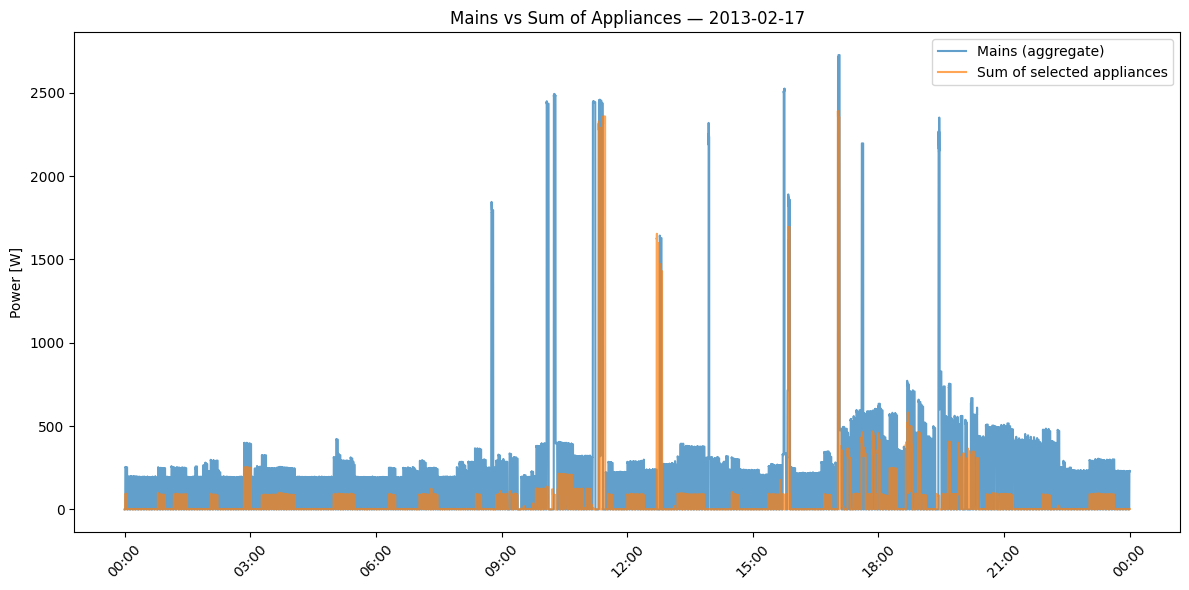

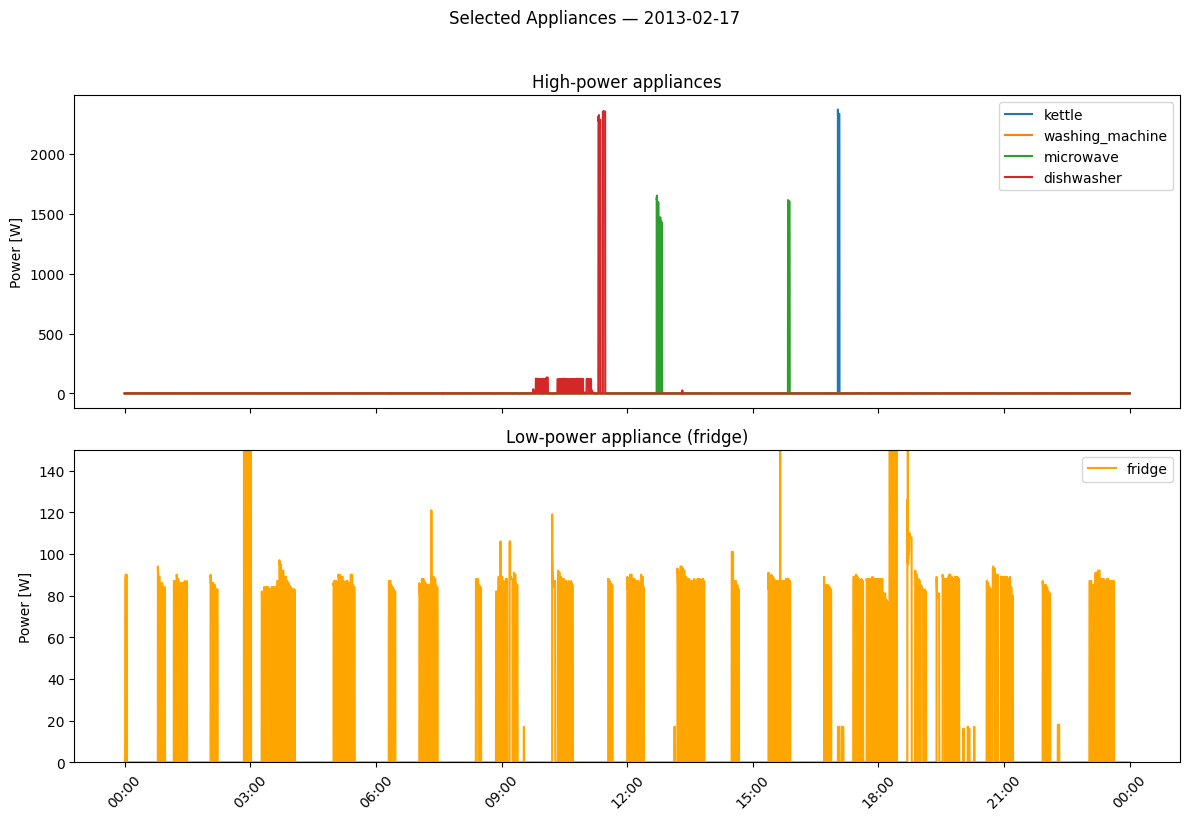

In [8]:
# ---- Pick one consistent day ----
day = df_mains.index.normalize().unique()[100]   # or whichever day you prefer
window = pd.concat([df_mains, df_appliances], axis=1).loc[day: day + pd.Timedelta(days=1)]
window["sum_appliances"] = df_appliances.loc[window.index].sum(axis=1)

# ---- Plot A: Mains vs Sum of Appliances ----
plt.figure(figsize=(12,6))
plt.plot(window.index, window["mains_W"], label="Mains (aggregate)", alpha=0.7)
plt.plot(window.index, window["sum_appliances"], label="Sum of selected appliances", alpha=0.7)
plt.legend()
plt.ylabel("Power [W]")
plt.title(f"Mains vs Sum of Appliances — {day.date()}")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---- Plot B & C: High-power vs Low-power Appliances ----
fig, axes = plt.subplots(2, 1, figsize=(12,8), sharex=True)

# High-power
for col in ["kettle", "washing_machine", "microwave", "dishwasher"]:
    if col in window.columns:
        axes[0].plot(window.index, window[col], label=col)
axes[0].legend()
axes[0].set_ylabel("Power [W]")
axes[0].set_title("High-power appliances")

# Low-power (fridge)
if "fridge" in window.columns:
    axes[1].plot(window.index, window["fridge"], label="fridge", color="orange")
    axes[1].set_ylim(0, 150)
    axes[1].legend()
    axes[1].set_ylabel("Power [W]")
    axes[1].set_title("Low-power appliance (fridge)")

for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax.tick_params(axis="x", rotation=45)

plt.suptitle(f"Selected Appliances — {day.date()}", y=1.02)
plt.tight_layout()
plt.show()


## 5. Detect Mains Events and Build Event Dataset  

**Transform the continuous mains signal into discrete events**  

We frame NILM as an **unsupervised event clustering problem**,  
converting the continuous `mains_W` series into a set of candidate appliance events.  

Steps performed:  
- **Detect** significant step changes (edges) in `mains_W`,  
- **Pair** ON events (+Δ) with the next OFF event (−Δ) within a maximum duration,  
- **Compute features** for each event:  
  - `amp_W` (power step size),  
  - `duration_s` (event length),  
  - `energy_Wh` (energy consumed),  
  - `hour_of_day` (contextual time feature).  

The resulting dataset, **`X_events`**, forms the input to the unsupervised models in the next step.  


In [9]:
# Tunable params for event detection
DELTA_MIN_W    = 50          # edge threshold (try 30–100 W)
MAX_PAIR_GAP_S = 45 * 60     # max ON–OFF pairing gap (45 min)

def detect_edges(series_w: pd.Series, thr_w: float) -> pd.DataFrame:
    """
    Detect step changes in mains power at 6 s cadence.
    Returns a DataFrame indexed by timestamp with:
      - delta_W (signed step), sign (+1 up, -1 down)
    """
    d = series_w.astype(float, copy=False).diff().fillna(0.0)
    hits = d[np.abs(d) >= thr_w]
    out = pd.DataFrame({"delta_W": hits, "sign": np.sign(hits).astype("int8")})
    out.index.name = "ts"
    return out.sort_index()

def pair_on_off(edges: pd.DataFrame, max_gap_s: int) -> pd.DataFrame:
    """
    Greedily pair each + edge with the earliest - edge after it, within max_gap_s.
    Unpaired ON edges get a synthetic OFF at t_on + max_gap_s.
    Unpaired OFF edges are ignored.
    """
    edges = edges.sort_index()
    pos = edges[edges["sign"] > 0]
    neg = edges[edges["sign"] < 0]
    neg_times = neg.index

    rows = []
    j = 0  # pointer into neg_times
    for t_on, row in pos.iterrows():
        while j < len(neg_times) and neg_times[j] <= t_on:
            j += 1

        t_off = None
        delta_off = np.nan
        k = j
        while k < len(neg_times):
            cand = neg_times[k]
            if (cand - t_on).total_seconds() <= max_gap_s:
                t_off = cand
                delta_off = float(edges.loc[cand, "delta_W"])
                j = k + 1
                break
            else:
                break

        if t_off is None:
            t_off = t_on + pd.Timedelta(seconds=max_gap_s)

        dur = (t_off - t_on).total_seconds()
        if dur <= 0:
            # skip pathological cases (duplicate timestamps or reversed order)
            continue

        rows.append({
            "t_on": t_on,
            "t_off": t_off,
            "delta_on_W": float(row["delta_W"]),
            "delta_off_W": delta_off,
            "duration_s": float(dur)
        })

    ev = pd.DataFrame(rows)
    # Defensive cap to avoid outliers sneaking in
    ev["duration_s"] = ev["duration_s"].clip(lower=6.0, upper=float(max_gap_s))
    return ev

def event_features(events: pd.DataFrame, series_w: pd.Series) -> pd.DataFrame:
    """
    Compute features per event window [t_on, t_off):
      - amp_W: absolute ON step size
      - duration_s
      - energy_Wh: sum over 6 s samples in the window
      - hour_of_day: hour at t_on (0–23)
    """
    feats = []
    s = series_w.astype(float, copy=False)
    dt_h = 6.0 / 3600.0

    for ev in events.itertuples():
        t0, t1 = ev.t_on, ev.t_off
        seg = s.loc[t0:t1]
        energy_Wh = float((seg * dt_h).sum())

        # hour extraction (tz-aware safe)
        try:
            hod = t0.tz_convert("UTC").hour
        except Exception:
            hod = t0.hour

        feats.append({
            "t_on": t0,
            "t_off": t1,
            "amp_W": abs(ev.delta_on_W),
            "duration_s": float(ev.duration_s),
            "energy_Wh": energy_Wh,
            "hour_of_day": int(hod),
        })

    feats = pd.DataFrame(feats).set_index("t_on").sort_index()
    # Stable column order
    return feats[["t_off", "amp_W", "duration_s", "energy_Wh", "hour_of_day"]]

# --- Pipeline: edges -> paired events -> features ---
edges_mains  = detect_edges(df_mains["mains_W"], thr_w=DELTA_MIN_W)
events_mains = pair_on_off(edges_mains, max_gap_s=MAX_PAIR_GAP_S)
X_events     = event_features(events_mains, df_mains["mains_W"])

# Health checks
n_edges  = len(edges_mains)
n_events = len(events_mains)
desc = X_events[["amp_W","duration_s","energy_Wh"]].describe().T

print(f"Detected edges:  {n_edges:,}")
print(f"Paired events:   {n_events:,}")
print("\nFeature summary (first 3 features):")
display(desc)
print("\nSample events:")
display(X_events.head(10))


Detected edges:  491,630
Paired events:   244,120

Feature summary (first 3 features):


,count,mean,std,min,25%,50%,75%,max
amp_W,244120.0,384.683549,433.193697,50.000000,183.00000,250.000000,412.00,6437.000000
duration_s,244120.0,865.145658,687.808903,6.000000,258.00000,684.000000,1314.00,2700.000000
energy_Wh,244120.0,72.037823,92.001709,0.543333,20.51625,43.023333,83.87,1441.713333



Sample events:


,t_off,amp_W,duration_s,energy_Wh,hour_of_day
t_on,,,,,
2012-11-09 22:32:21+00:00,2012-11-09 22:35:03+00:00,578.0,162.0,26.508333,22
2012-11-09 22:36:39+00:00,2012-11-09 22:39:27+00:00,510.0,168.0,24.331667,22
2012-11-09 22:41:09+00:00,2012-11-09 22:43:33+00:00,475.0,144.0,18.558333,22
2012-11-09 22:45:21+00:00,2012-11-09 22:47:57+00:00,369.0,156.0,17.163333,22
2012-11-09 22:49:39+00:00,2012-11-09 22:52:27+00:00,351.0,168.0,16.058333,22
2012-11-09 22:54:27+00:00,2012-11-09 22:57:09+00:00,344.0,162.0,15.598333,22
2012-11-09 22:58:45+00:00,2012-11-09 23:01:21+00:00,355.0,156.0,15.358333,22
2012-11-09 23:03:03+00:00,2012-11-09 23:05:51+00:00,356.0,168.0,17.005000,23
2012-11-09 23:07:27+00:00,2012-11-09 23:10:03+00:00,367.0,156.0,15.913333,23


### 5.1 Sanity Visualizations for Event Features  

**Validate extracted events using linear and log-scale views**  

To ensure our event extraction is correct,  
we visualize the per-event features on both **linear** and **logarithmic** scales.  

- **Linear scale (histograms + scatter):**  
  Shows absolute counts of events. Highlights frequent small events (e.g., fridge cycles),  
  but rare large events are less visible.  

- **Log scale (log–log histograms):**  
  Rescales both axes to reveal long-tailed distributions.  
  Makes rare, high-power or long-duration events (e.g., dishwasher, washing machine) more apparent.  

By comparing these two perspectives,  
we confirm that the dataset contains many small events plus fewer distinct high-power events—  
a characteristic signature of NILM datasets.  


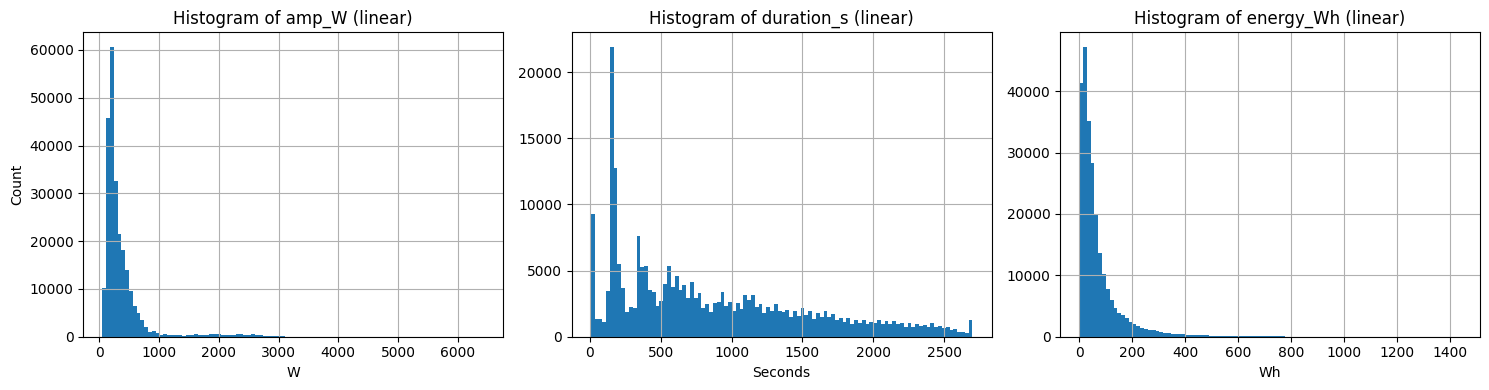

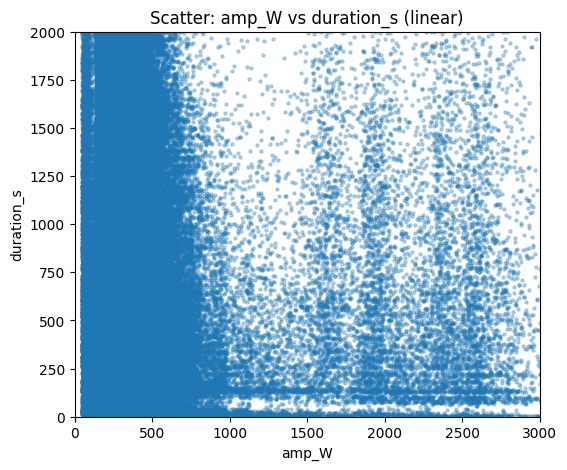

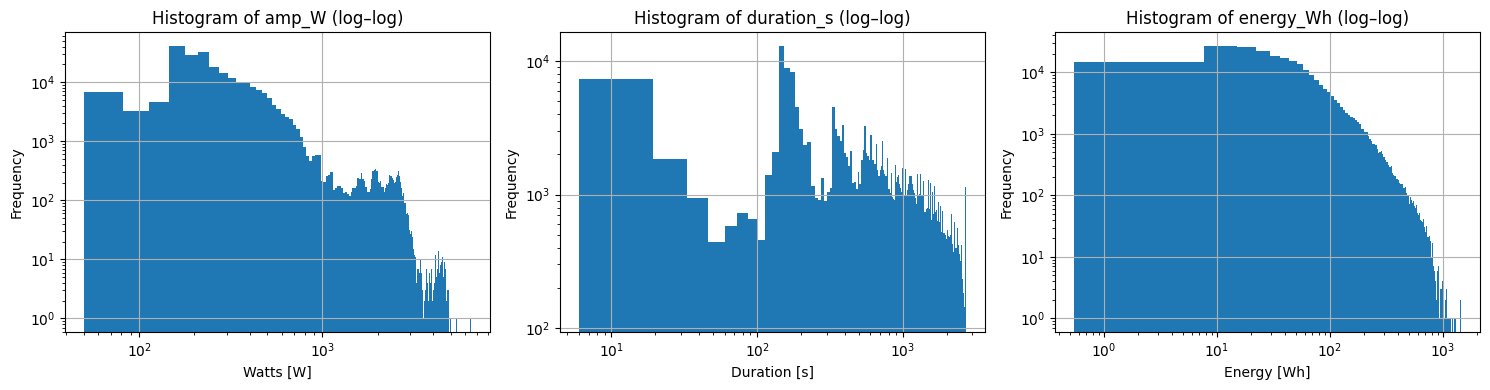

In [10]:
# --- Linear scale histograms ---
fig, axes = plt.subplots(1, 3, figsize=(15,4))
X_events["amp_W"].hist(bins=100, ax=axes[0])
axes[0].set_title("Histogram of amp_W (linear)")
axes[0].set_xlabel("W")
axes[0].set_ylabel("Count")

X_events["duration_s"].hist(bins=100, ax=axes[1])
axes[1].set_title("Histogram of duration_s (linear)")
axes[1].set_xlabel("Seconds")

X_events["energy_Wh"].hist(bins=100, ax=axes[2])
axes[2].set_title("Histogram of energy_Wh (linear)")
axes[2].set_xlabel("Wh")

plt.tight_layout()
plt.show()

# --- Scatter plot (linear) ---
plt.figure(figsize=(6,5))
plt.scatter(X_events["amp_W"], X_events["duration_s"], s=5, alpha=0.3)
plt.xlim(0, 3000)   # focus on main cluster region
plt.ylim(0, 2000)
plt.xlabel("amp_W")
plt.ylabel("duration_s")
plt.title("Scatter: amp_W vs duration_s (linear)")
plt.show()

# --- Log scale histograms ---
fig, axes = plt.subplots(1, 3, figsize=(15,4))
for col, ax, label in zip(["amp_W", "duration_s", "energy_Wh"],
                          axes, ["Watts [W]", "Duration [s]", "Energy [Wh]"]):
    X_events[col].hist(bins=200, ax=ax)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(label)
    ax.set_ylabel("Frequency")
    ax.set_title(f"Histogram of {col} (log–log)")

plt.tight_layout()
plt.show()


### 5.3 Time-of-Day Distribution of Events  

**Reveal daily routines through event timing**  

Appliance usage is strongly shaped by household routines.  
By plotting event counts against **`hour_of_day`**,  
we can observe when appliances are most active.  

Expected patterns include:  
- **Kettle & microwave:** peaks around breakfast, lunch, and dinner,  
- **Fridge:** steady, uniform activity across the day (due to regular cycles),  
- **Dishwasher & washing machine:** clustered mainly in the evening hours.  

This provides an initial **behavioral fingerprint** of appliance activity  
before applying clustering methods.  


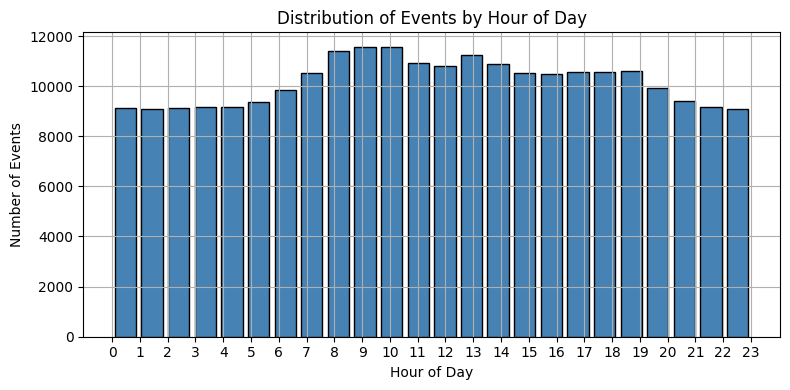

In [11]:
# Histogram of event start times (hour of day)
plt.figure(figsize=(8,4))
X_events["hour_of_day"].hist(bins=24, rwidth=0.8, color="steelblue", edgecolor="black")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Events")
plt.title("Distribution of Events by Hour of Day")
plt.xticks(range(0,24))
plt.tight_layout()
plt.show()

## 6. Build Ground-Truth Events from Appliance Channels  

**Create labeled events for evaluation**  

To evaluate the performance of our unsupervised clustering,  
we construct **ground-truth labels** from the sub-metered appliance channels provided by UK-DALE.  

Process:  
- Detect **ON/OFF events** for each appliance (e.g., kettle, fridge, washing machine),  
- Use the same **5 W threshold** and **6-second cadence** applied to the mains,  
- Preserve the **appliance names** as labels for each event.  

These ground-truth labels are reserved **only for evaluation**,  
ensuring that our clustering remains entirely unsupervised during training.  


In [12]:
# Fix for tz-aware index handling inside build_appliance_events
def build_appliance_events(df_appliances: pd.DataFrame, appliances: list[str], threshold: float = 5.0) -> pd.DataFrame:
    """
    Extract ON events for selected appliances from appliance channels.
    Returns one row per detected ON interval with appliance label + features.
    """
    records = []

    for app in appliances:
        if app not in df_appliances.columns:
            continue

        series = pd.to_numeric(df_appliances[app], errors="coerce").fillna(0.0)

        # Binary on/off with threshold, detect rising/falling edges
        on_mask = (series > threshold).astype("int8")
        changes = on_mask.diff().fillna(0)

        on_times  = series.index[changes == 1]
        off_times = series.index[changes == -1]

        # If it ends ON, close the last interval at the final timestamp
        if len(off_times) < len(on_times):
            # Ensure both are tz-aware consistently
            last_time = series.index[-1]
            off_times = off_times.append(pd.DatetimeIndex([last_time]))

        for t_on, t_off in zip(on_times, off_times):
            dur_s = (t_off - t_on).total_seconds()
            if dur_s <= 0:
                continue

            seg = series.loc[t_on:t_off]
            amp_W = float(seg.max() - seg.min())
            energy_Wh = float(seg.mean() * dur_s / 3600.0)

            # hour-of-day robust to tz-aware index
            hod = t_on.hour if t_on.tzinfo is None else t_on.tz_convert("UTC").hour

            records.append({
                "appliance": app,
                "t_on": t_on,
                "t_off": t_off,
                "amp_W": amp_W,
                "duration_s": float(dur_s),
                "energy_Wh": energy_Wh,
                "hour_of_day": int(hod),
            })

    events = pd.DataFrame.from_records(records)
    if not events.empty:
        events = events.sort_values("t_on").reset_index(drop=True)
        events = events[["appliance", "t_on", "t_off", "amp_W", "duration_s", "energy_Wh", "hour_of_day"]]
    return events

# Re-run Step 6
selected_apps = ["fridge", "kettle", "washing_machine", "dishwasher", "microwave"]
appliance_events = build_appliance_events(df_appliances, selected_apps)

print(f"Extracted {len(appliance_events)} appliance events across {len(selected_apps)} appliances")
display(appliance_events.head())


Extracted 70785 appliance events across 5 appliances


,appliance,t_on,t_off,amp_W,duration_s,energy_Wh,hour_of_day
0,dishwasher,2012-11-09 23:38:03+00:00,2012-11-09 23:40:39+00:00,24.0,156.0,0.394815,23
1,dishwasher,2012-11-09 23:42:09+00:00,2012-11-09 23:44:57+00:00,124.0,168.0,5.546897,23
2,dishwasher,2012-11-09 23:46:57+00:00,2012-11-09 23:49:51+00:00,123.0,174.0,5.745222,23
3,dishwasher,2012-11-09 23:51:15+00:00,2012-11-09 23:53:57+00:00,123.0,162.0,5.301964,23
4,dishwasher,2012-11-09 23:55:45+00:00,2012-11-09 23:55:51+00:00,103.0,6.0,0.085833,23


### 6.1 Visualize Appliance Events  

**Compare event fingerprints across appliances**  

We plot the event features for each appliance to examine differences in:  
- `amp_W` (power step size),  
- `duration_s` (event length),  
- `energy_Wh` (energy consumed).  

These visualizations reveal the **distinct fingerprints** that clustering should capture.  
For example:  
- **Kettle:** high power, short duration spikes,  
- **Fridge:** low power, frequent short cycles,  
- **Dishwasher / washing machine:** longer, high-energy events.  

This step provides intuition for how appliances separate in feature space.  


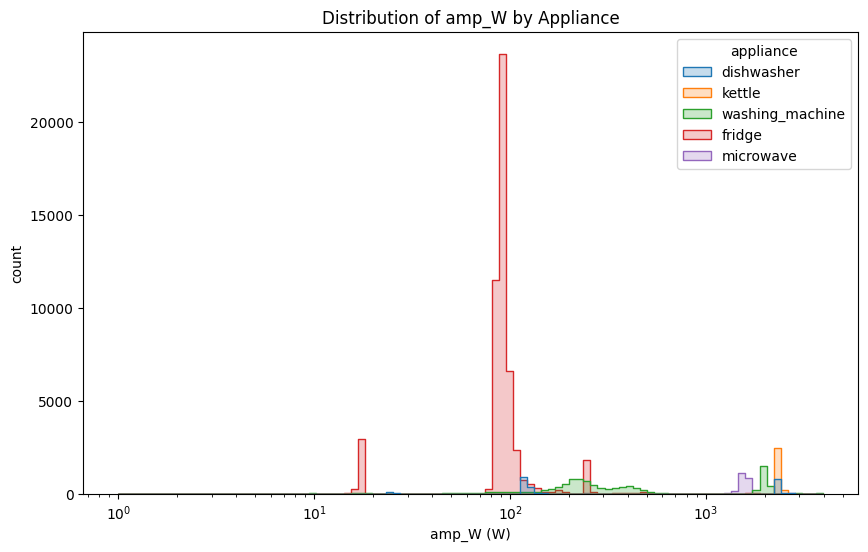

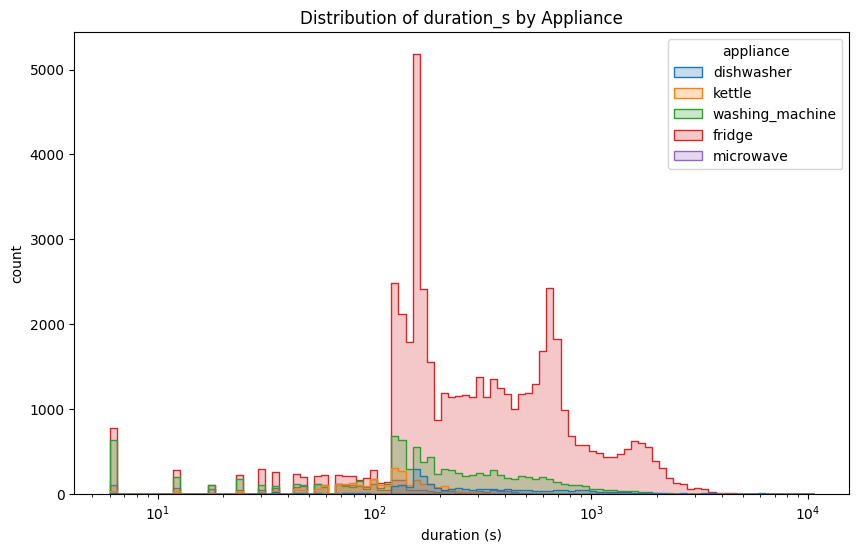

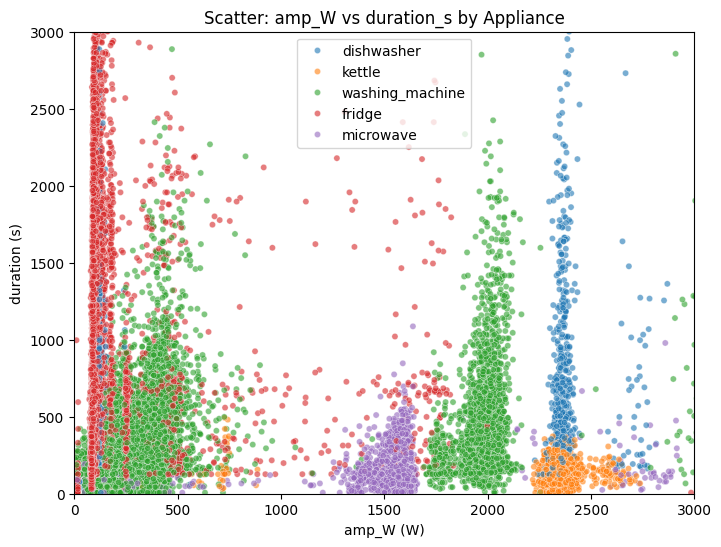

In [13]:
# Histogram of amp_W by appliance
plt.figure(figsize=(10,6))
sns.histplot(data=appliance_events, x="amp_W", hue="appliance", element="step", bins=100, log_scale=(True, False))
plt.title("Distribution of amp_W by Appliance")
plt.xlabel("amp_W (W)")
plt.ylabel("count")
plt.show()

# Histogram of duration_s by appliance
plt.figure(figsize=(10,6))
sns.histplot(data=appliance_events, x="duration_s", hue="appliance", element="step", bins=100, log_scale=(True, False))
plt.title("Distribution of duration_s by Appliance")
plt.xlabel("duration (s)")
plt.ylabel("count")
plt.show()

# Scatter: amp_W vs duration_s (colored by appliance)
plt.figure(figsize=(8,6))
sns.scatterplot(data=appliance_events, x="amp_W", y="duration_s", hue="appliance", alpha=0.6, s=20)
plt.xlim(0, 3000)
plt.ylim(0, 3000)
plt.title("Scatter: amp_W vs duration_s by Appliance")
plt.xlabel("amp_W (W)")
plt.ylabel("duration (s)")
plt.legend()
plt.show()

## 7. Apply Clustering to Mains Events  

**Clustering mains events with KMeans**  

 
We now apply an unsupervised clustering algorithm to the event features extracted from mains (Step 5).  
We use **KMeans** to group similar events based on:  
- power step size (`amp_W`),  
- duration (`duration_s`),  
- energy consumed (`energy_Wh`),  
- and time of day (`hour_of_day`).  

The number of clusters is a hyperparameter; for interpretability we start with **k = 5**, corresponding roughly to our selected appliances (fridge, kettle, microwave, washing machine, dishwasher).  

These clusters will later be compared to the appliance ground-truth events (Step 6).


Cluster counts:
cluster
3    87761
0    80250
2    56204
1    10083
4     9822
Name: count, dtype: int64


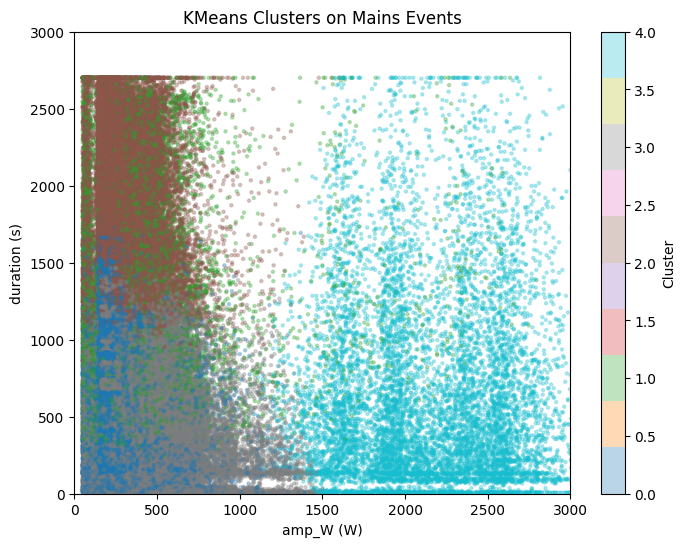

In [14]:
features = ["amp_W", "duration_s", "energy_Wh", "hour_of_day"]

# Scale features (important for clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_events[features])

# Fit KMeans with k=5 clusters
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Store results
X_events["cluster"] = clusters

print("Cluster counts:")
print(X_events["cluster"].value_counts())

# Quick visualization: amp_W vs duration_s colored by cluster
plt.figure(figsize=(8,6))
plt.scatter(
    X_events["amp_W"], 
    X_events["duration_s"], 
    c=X_events["cluster"], 
    cmap="tab10", 
    s=5, alpha=0.3
)
plt.xlim(0, 3000)
plt.ylim(0, 3000)
plt.xlabel("amp_W (W)")
plt.ylabel("duration (s)")
plt.title("KMeans Clusters on Mains Events")
plt.colorbar(label="Cluster")
plt.show()

### 7.1 Visualize Clusters with PCA  

**PCA projection of clustered events** 
 
To better understand the clustering, we reduce the **4D feature space** (`amp_W`, `duration_s`, `energy_Wh`, `hour_of_day`) into **2 principal components** using PCA.  
The clusters from KMeans are then visualized in this reduced 2D space.  

This allows us to see whether clusters overlap or form distinct groups, beyond the raw `amp_W` vs `duration_s` scatter.


Explained variance ratio (PCA): [0.36690722 0.29702053]


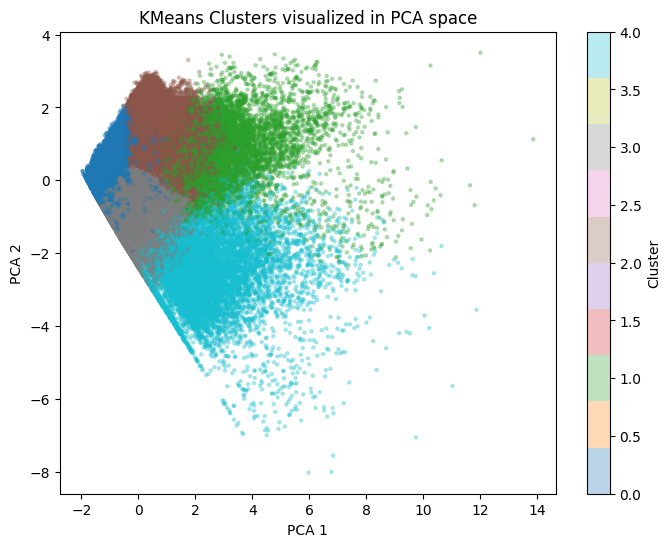

In [15]:
# Step 7b: PCA projection
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Add PCA results to dataframe
X_events["pca1"] = X_pca[:, 0]
X_events["pca2"] = X_pca[:, 1]

print("Explained variance ratio (PCA):", pca.explained_variance_ratio_)

# Plot clusters in PCA space
plt.figure(figsize=(8,6))
plt.scatter(
    X_events["pca1"], 
    X_events["pca2"], 
    c=X_events["cluster"], 
    cmap="tab10", 
    s=5, alpha=0.3
)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("KMeans Clusters visualized in PCA space")
plt.colorbar(label="Cluster")
plt.show()


## 8. Evaluate Clusters Against Appliance Ground Truth  

**Compare unsupervised clusters with labeled appliance events**  

With both inputs prepared—  
- **Unsupervised clusters** from mains events (Step 7),  
- **Ground-truth appliance events** from sub-metered channels (Step 6)—  
we can now assess clustering performance.  

Evaluation process:  
1. **Assign clusters** to the appliance they best represent using majority voting,  
2. **Construct a confusion matrix** to visualize misclassifications,  
3. **Compute metrics** (precision, recall, and F1-score) for each appliance.  

This step measures how well the unsupervised clustering aligns with true appliance behavior.  


In [16]:
common_features = ["amp_W", "duration_s", "energy_Wh", "hour_of_day"]

# Scale appliance events using the same scaler as Step 7
appliance_scaled = scaler.transform(appliance_events[common_features])

# Predict clusters for appliance events
appliance_clusters = kmeans.predict(appliance_scaled)
appliance_events["cluster"] = appliance_clusters

# Majority-vote mapping: assign each cluster to most common appliance
mapping = {}
for c in np.unique(appliance_clusters):
    subset = appliance_events[appliance_events["cluster"] == c]
    if len(subset) > 0:
        majority_label = subset["appliance"].mode()[0]
        mapping[c] = majority_label

print("Cluster → Appliance mapping:")
print(mapping)

# Map cluster labels to appliance predictions
appliance_events["predicted_app"] = appliance_events["cluster"].map(mapping)

# Confusion matrix
cm = confusion_matrix(
    appliance_events["appliance"],
    appliance_events["predicted_app"],
    labels=selected_apps
)

print("Confusion Matrix (rows=true, cols=pred):")
print(pd.DataFrame(cm, index=selected_apps, columns=selected_apps))

# Classification report (precision, recall, F1)
print("\nClassification Report:")
print(classification_report(
    appliance_events["appliance"],
    appliance_events["predicted_app"],
    digits=3
))

Cluster → Appliance mapping:
{np.int32(0): 'fridge', np.int32(1): 'washing_machine', np.int32(2): 'fridge', np.int32(3): 'fridge', np.int32(4): 'kettle'}
Confusion Matrix (rows=true, cols=pred):
                 fridge  kettle  washing_machine  dishwasher  microwave
fridge            52323     137                0           0          0
kettle               70    2747                0           0          0
washing_machine    8239    2172               81           0          0
dishwasher         1618     847               44           0          0
microwave           375    2131                1           0          0

Classification Report:


C:\Users\magnu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


                 precision    recall  f1-score   support

     dishwasher      0.000     0.000     0.000      2509
         fridge      0.835     0.997     0.909     52460
         kettle      0.342     0.975     0.506      2817
      microwave      0.000     0.000     0.000      2507
washing_machine      0.643     0.008     0.015     10492

       accuracy                          0.779     70785
      macro avg      0.364     0.396     0.286     70785
   weighted avg      0.728     0.779     0.696     70785



C:\Users\magnu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\magnu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


### 8b. Visualize Clusters vs Appliance Ground Truth  

**Overlay appliance labels on PCA clusters**  

To interpret the misclassifications from the confusion matrix,  
we reuse the **PCA projection** from Step 7b.  

Two visualizations are created:  
- **True labels:** events colored by their ground-truth appliance class,  
- **Predicted labels:** events colored by their assigned cluster-to-appliance mapping.  

By comparing these views,  
we can see where appliances naturally overlap in feature space (e.g., kettle vs fridge),  
and where **KMeans** clustering has difficulty separating them.  


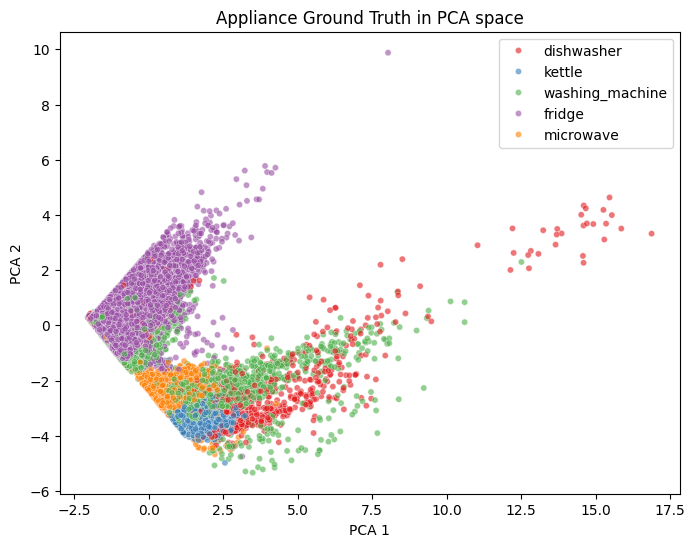

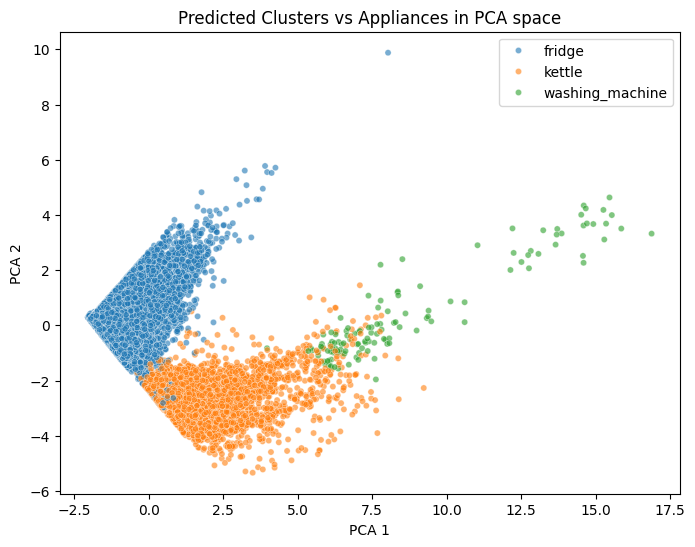

In [17]:
# Project appliance events into the same PCA space used for mains
appliance_pca = pca.transform(appliance_scaled)
appliance_events["pca1"] = appliance_pca[:,0]
appliance_events["pca2"] = appliance_pca[:,1]

# Plot 1: true appliance labels in PCA space
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=appliance_events,
    x="pca1", y="pca2",
    hue="appliance", palette="Set1",
    alpha=0.6, s=20
)
plt.title("Appliance Ground Truth in PCA space")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.show()

# Plot 2: predicted clusters (mapped to appliances) in PCA space
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=appliance_events,
    x="pca1", y="pca2",
    hue="predicted_app", palette="tab10",
    alpha=0.6, s=20
)
plt.title("Predicted Clusters vs Appliances in PCA space")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.show()


## 9. Apply PCA with KMeans and Evaluate  

**Compare clustering with and without dimensionality reduction**  

To meet the assignment requirement,  
we combine **Principal Component Analysis (PCA)** with KMeans clustering  
and compare the results to the baseline clustering from Steps 7–8.  

Process:  
1. **Reduce** the feature space (`amp_W`, `duration_s`, `energy_Wh`, `hour_of_day`)  
   into **2 principal components**,  
2. **Cluster** the reduced feature space using **KMeans**,  
3. **Re-evaluate performance** against ground-truth appliance events (Step 6),  
4. **Compare results** with the baseline clustering (without PCA).  

This allows us to see whether dimension reduction improves separability  
or leads to information loss in appliance event clustering.  


In [18]:
# 1) Reduce to 2D with PCA
pca_clust = PCA(n_components=2, random_state=42)
X_pca_clust = pca_clust.fit_transform(X_scaled)

# 2) KMeans on PCA features
kmeans_pca = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters_pca = kmeans_pca.fit_predict(X_pca_clust)

X_events["cluster_pca"] = clusters_pca

print("Explained variance by 2D PCA for clustering:", pca_clust.explained_variance_ratio_.sum())

# 3) Re-evaluate with ground-truth appliances
appliance_pca_eval = pca_clust.transform(appliance_scaled)
appliance_clusters_pca = kmeans_pca.predict(appliance_pca_eval)
appliance_events["cluster_pca"] = appliance_clusters_pca

# Majority-vote mapping (PCA version)
mapping_pca = {}
for c in np.unique(appliance_clusters_pca):
    subset = appliance_events[appliance_events["cluster_pca"] == c]
    if len(subset) > 0:
        majority_label = subset["appliance"].mode()[0]
        mapping_pca[c] = majority_label

print("Cluster → Appliance mapping (PCA):", mapping_pca)

# Apply mapping
appliance_events["predicted_app_pca"] = appliance_events["cluster_pca"].map(mapping_pca)

# 4) Confusion matrix and classification report
cm_pca = confusion_matrix(
    appliance_events["appliance"],
    appliance_events["predicted_app_pca"],
    labels=selected_apps
)

print("Confusion Matrix (rows=true, cols=pred, PCA version):")
print(pd.DataFrame(cm_pca, index=selected_apps, columns=selected_apps))

print("\nClassification Report (PCA version):")
print(classification_report(
    appliance_events["appliance"],
    appliance_events["predicted_app_pca"],
    digits=3
))


Explained variance by 2D PCA for clustering: 0.6639277463338642
Cluster → Appliance mapping (PCA): {np.int32(0): 'fridge', np.int32(1): 'kettle', np.int32(2): 'fridge', np.int32(3): 'fridge', np.int32(4): 'fridge'}
Confusion Matrix (rows=true, cols=pred, PCA version):
                 fridge  kettle  washing_machine  dishwasher  microwave
fridge            52428      32                0           0          0
kettle               77    2740                0           0          0
washing_machine    8478    2014                0           0          0
dishwasher         1664     845                0           0          0
microwave          2020     487                0           0          0

Classification Report (PCA version):


C:\Users\magnu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


                 precision    recall  f1-score   support

     dishwasher      0.000     0.000     0.000      2509
         fridge      0.811     0.999     0.895     52460
         kettle      0.448     0.973     0.613      2817
      microwave      0.000     0.000     0.000      2507
washing_machine      0.000     0.000     0.000     10492

       accuracy                          0.779     70785
      macro avg      0.252     0.394     0.302     70785
   weighted avg      0.619     0.779     0.688     70785



C:\Users\magnu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\magnu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


### 9b. Side-by-Side Visualization: Baseline vs PCA Clustering  

**Visually compare clustering pipelines with and without PCA**  

We present the results of the two clustering approaches side by side:  
- **Left:** baseline KMeans predictions (no dimension reduction),  
- **Right:** PCA(2) + KMeans predictions.  

For both pipelines, predicted clusters are mapped to appliance names.  
In addition, we compute compact evaluation metrics—  
**accuracy** and **macro-F1**—to include in the report.  

This combined view highlights whether PCA improved clustering,  
reduced performance, or simply compressed the feature space  
without major impact on appliance separation.  


Baseline (no DR):    accuracy=0.779 | macro-F1=0.286
PCA(2)+KMeans:       accuracy=0.779 | macro-F1=0.302


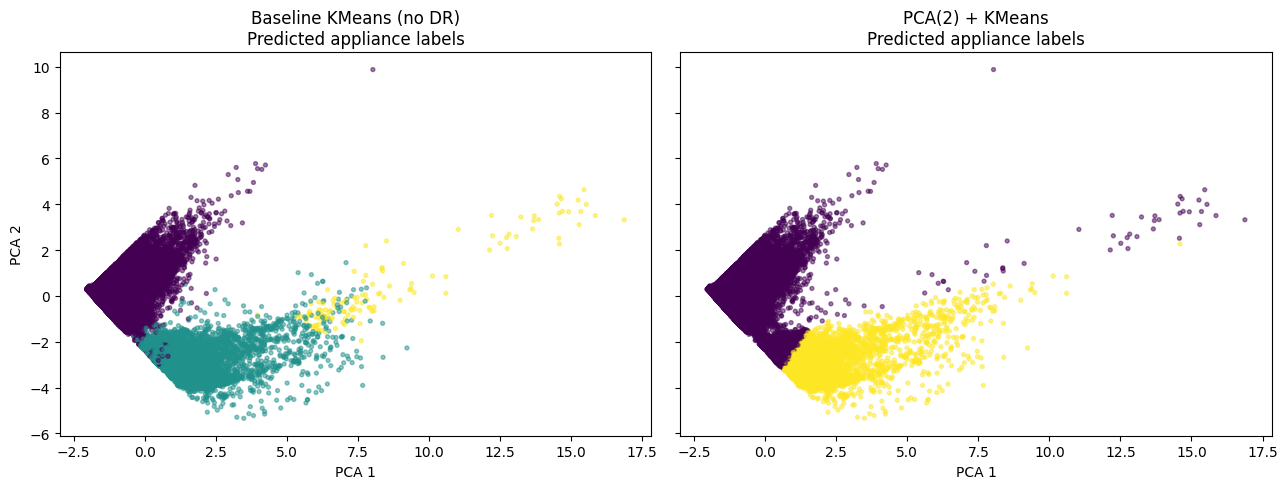

In [19]:
# Baseline (no PCA)
report_base = classification_report(
    appliance_events["appliance"],
    appliance_events["predicted_app"],
    output_dict=True,
    zero_division=0
)
acc_base  = report_base["accuracy"]
f1m_base  = report_base["macro avg"]["f1-score"]

# PCA pipeline
report_pca = classification_report(
    appliance_events["appliance"],
    appliance_events["predicted_app_pca"],
    output_dict=True,
    zero_division=0
)
acc_pca   = report_pca["accuracy"]
f1m_pca   = report_pca["macro avg"]["f1-score"]


print(f"Baseline (no DR):    accuracy={acc_base:.3f} | macro-F1={f1m_base:.3f}")
print(f"PCA(2)+KMeans:       accuracy={acc_pca:.3f} | macro-F1={f1m_pca:.3f}")

# --- Side-by-side scatter in the SAME PCA space used for Step 8b ---
fig, axes = plt.subplots(1, 2, figsize=(13,5), sharex=True, sharey=True)

# Left: baseline predictions (mapped)
axes[0].scatter(
    appliance_events["pca1"], appliance_events["pca2"],
    c=appliance_events["predicted_app"].astype("category").cat.codes,
    s=8, alpha=0.5
)
axes[0].set_title("Baseline KMeans (no DR)\nPredicted appliance labels")
axes[0].set_xlabel("PCA 1"); axes[0].set_ylabel("PCA 2")

# Right: PCA+KMeans predictions (mapped)
axes[1].scatter(
    appliance_events["pca1"], appliance_events["pca2"],
    c=appliance_events["predicted_app_pca"].astype("category").cat.codes,
    s=8, alpha=0.5
)
axes[1].set_title("PCA(2) + KMeans\nPredicted appliance labels")
axes[1].set_xlabel("PCA 1")

plt.tight_layout()
plt.show()


## 10. Report Packaging: Pipeline Summary and Results  

**Summarize the NILM pipeline, findings, and improvements**  

This step consolidates the full workflow into a structured summary,  
highlighting methods, results, pros/cons, and possible improvements.  
It also provides guidance for writing the exam report (Sections 2.1–2.2).  

---

**Pipeline (for report figure/diagram)**  
1. **Load dataset** (House 1, UK-DALE),  
2. **Preprocessing**: resample @6s, fill gaps <2 min, threshold 5 W,  
3. **Event extraction**: ON/OFF detection → features (`amp_W`, `duration_s`, `energy_Wh`, `hour_of_day`),  
4. **Ground-truth events**: fridge, kettle, microwave, washing machine, dishwasher,  
5. **Unsupervised clustering**:  
   - Baseline: KMeans on 4D features,  
   - With DR: PCA(2) + KMeans,  
6. **Evaluation**: confusion matrix, precision/recall, PCA overlays.  

---

**Key Results**  
- **Baseline (no PCA):**  
  - Accuracy ≈ 0.779 (inflated by fridge imbalance),  
  - Macro-F1 ≈ 0.286,  
  - Fridge: perfect recall, strong precision,  
  - Kettle: high recall, low precision,  
  - Washing machine & dishwasher: partial recognition,  
  - Microwave: mostly lost.  

- **PCA + KMeans:**  
  - Accuracy ≈ 0.779 (unchanged),  
  - Macro-F1 ≈ 0.302 (slight improvement),  
  - Kettle: improved precision + recall,  
  - Washing machine, dishwasher, microwave: collapsed (recall = 0).  

---

**Pros and Cons of PCA**  
**Pros**  
- Simplifies feature space,  
- Clearer separation for very distinct appliances (e.g., kettle).  

**Cons**  
- Discards variance needed for subtle appliances,  
- Amplifies class imbalance (smaller appliances get lost).  

---

**Potential Improvements**  
- Explore alternative clustering: **DBSCAN** or **Gaussian Mixture Models**,  
- Add richer features: time-of-day windows, rolling averages, harmonics,  
- Handle imbalance: downsample fridge or weight clusters,  
- Test higher PCA dimensions (PCA(3) or PCA(4)),  
- Investigate semi-supervised approaches to guide clustering with partial labels.  

